# Murrieta León Juan Eduardo
# Tarea: Análisis de actividad sísmica

# Análisis de actividad sísmica en México

![Alerta](im.png)

Para los que tengan curiosidad de ver cómo se sacó la información de la página del SSN, hay otro .ipynb en este folder donde se explica detalladamente. Lo primero que hay que hacer es cargar los paquetes necesarios. Esto significa importar (e instalar anteriormente) los siguientes paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from helpers.Mexico import Republica

republica = Republica()

sns.set_style("darkgrid")

El paquete de seaborn lo pueden instalar con pip3, al igual que folium. helpers.Mexico es un paquete que yo hice para ayudarles un poco, de ahí saco la clase `Republica`.

De los paquetes necesarios, `Folium` es por mucho el más complejo. Permite hacer mapas interactivos en jupyter. Yo me he dado a la tarea de bajar del inegi las divisiones políticas del país y pasarlas a un formato que `Folium` entiende, conocido como topojson. El archivo se encuentra en el folder `helpers`. No es necesario que entiendan su contenido, pero yo les explicaré más adelante su uso.

Carguemos rápidamente el csv de la actividad sísmica reportada por el SSN de la UNAM desde el 1 de Enero de 1990 hasta el 17 de Febrero del 2018. Además de cargar el csv, vamos a ver los primeros 5 renglones, para familiarizarnos con el formato:

In [2]:
#Definimos una lambda que convierta una cadena de caracteres en una etiqueta de tiempo.
mConverters = {'Fecha y Hora': lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') }
#Usamos la lambda para cargar el csv. Los nombres de las columnas son el primer renglón
sismos = pd.read_csv('helpers/earthquakes.csv', index_col = 0, converters = mConverters)
#Mostremos los primeros 5 renglones con la función head
sismos.head()

,Magnitud,Latitud,Longitud,Profundidad (km),Fecha y Hora
0,3.2,15.83,-98.41,17,2018-02-17 23:57:31
1,2.8,16.28,-98.08,12,2018-02-17 23:56:51
2,3.1,16.21,-98.02,10,2018-02-17 23:53:03
3,2.8,16.03,-97.75,16,2018-02-17 23:52:22
4,4.1,32.64,-115.18,4,2018-02-17 23:49:44


El csv es muy, muy sencillo. Contiene sólo 5 columnas: Magnitud, Latitud, Longitud, Profundidad y Fecha-Hora. Las primeras tres columnas son flotantes, mientras la quinta es una estampa de tiempo. Tendrán que aprender a usar estampas de tiempo pero yo les puedo ayudar.

## Ejercicio 1: Magnitud de los sismos

Calculen las siguientes cantidades (explicando en su código cómo lo hacen):
1. Cuenta total de sismos
2. Rango de magnitud de los sismos
3. Número de sismos por cada categoría, siendo las categorías {[1,2), [2,3),[3,4),[4,5),[5,6),[6,7),[7,8),[8,9)}
3. Número de sismos en cada año, graficado como un histograma (¿Ha aumentado la actividad sísmica?)

In [3]:
# 1.1 Cuenta total de sismos
# Imprime el total de registros en el dataframe sismos
print ('Total de sismos: ',sismos.shape[0])

Total de sismos:  105946


In [4]:
# 1.2 Rango de magnitud de sismos
# Imprime el rango [min,max] de la magnitud de los sismos
print ('Rango: [%2.1f,%2.1f]'%(sismos['Magnitud'].min(),sismos['Magnitud'].max()))

Rango: [1.2,8.2]


In [5]:
# 1.3 Número de sismos por categoría
# Imprime un tabla con la cantidad de sismos clasificados por su magnitud
mbins=np.arange(1,10,1)
categorias=sismos.groupby(pd.cut(sismos['Magnitud'],mbins,right=False,include_lowest=True)).size()
print(categorias)

Magnitud
[1, 2)       54
[2, 3)     1961
[3, 4)    79319
[4, 5)    23613
[5, 6)      883
[6, 7)       98
[7, 8)       16
[8, 9)        2
dtype: int64


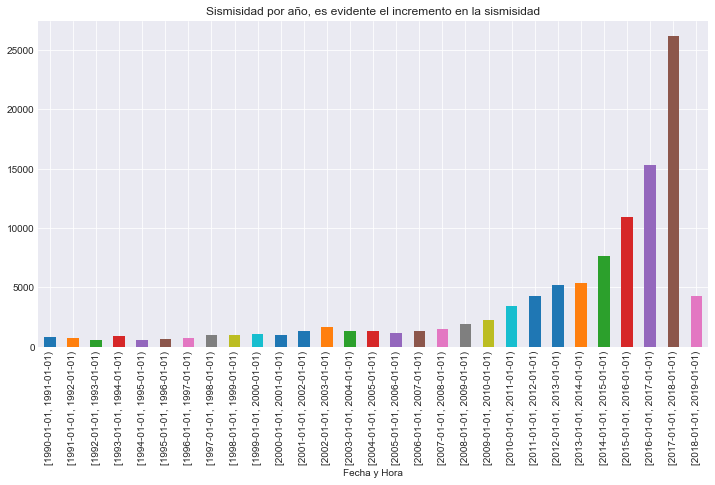

In [6]:
# 1.4 Número de sismos por años
# Histograma de sismos por año
#
# Determina el rango en años para los bines
yrange=sismos['Fecha y Hora'].max().year-sismos['Fecha y Hora'].min().year+2
# Crea los bines
ybins=pd.to_datetime(pd.DataFrame({'year':np.arange(sismos['Fecha y Hora'].min().year,sismos['Fecha y Hora'].max().year+2,1),
                   'month':np.ones(yrange),'day':np.ones(yrange)}))
# Clasifica los sismos de acuerdo a los bines por año
sXa=sismos.groupby(pd.cut(sismos['Fecha y Hora'],ybins,right=False,include_lowest=True)).size()
sXa.plot.bar(title='Sismisidad por año, es evidente el incremento en la sismisidad',figsize=(12,6))

Del gráfico se observa que la sismisidad se ha incrementado exponencialmente desde 2009. 

## Ejercicio 2: Graficando en el mapa

Para lo que viene, ustedes deben añadir una columna de nombre "Estado" al DataFrame `sismos`. Para ello, la variable `republica` declarada al principio del documento tiene una función llamada `estadoSegunPunto` que recibe como parámetros un par de números (latitud y longitud) y dice en qué estado de la república ocurrió el sismo (por ejemplo `republica.estadoSegunPunto(19,-100)`. La función devuelve `np.nan` si el punto no se encuentra dentro de un estado. Como ejercicio:

1. Calculen el porcentaje de epicentros dentro del territorio mexicano (en este caso el mar no cuenta).
2. Calculen cuántos sismos ocurrieron por estado.
3. Determinen cual es el estado con menor actividad sísmica (en cuanto a epicentros) y cuál el de mayor
4. Hagan un mapa de colores de la actividad sísmica por estado. Agarren buenos colores y usen una buena escala.

Para el cuarto punto, utilicen `Folium`. Les dejo el tip: las funciones que necesitan son `folium.Map()` (que genera un objeto, llamémoslo `mexmap`) y la función `.choropleth` (miembro de `mexmap`). Hay ejemplos en internet de esto, pero si tienen dudas y están muy muy frustrados, mándenme un correo y les ayudo un poco. Para generar el _choropleth_, necesitan el archivo `helpers/mexican_states.geojson`, la función `choropleth` se los va a pedir pero no tienen que entender lo que hay dentro. Ah, eso sí, los nombres de los estados están etiquetados por el nombre "NOM_ENT" (`choropleth` se los va a pedir...).

In [7]:
# 2.1 Porcentaje de epicentros en el territorio mexicano
#
# NOTA: esta parte demora bastante.
#
sismos['Estado']=pd.Series(map(lambda x: republica.estadoSegunPunto(sismos.iloc[x]['Latitud'],sismos.iloc[x]['Longitud']),
                               range(0,sismos.shape[0])),index=sismos.index)

sismosMx=sismos.loc[sismos['Estado'].isna()==False]
print ('Epicentros en territorio mexicano: %3.2f%%' % (100*sismosMx.shape[0]/sismos.shape[0]))

Epicentros en territorio mexicano: 43.97%


In [8]:
# 2.2 Sismos por Estado
sismosMx.groupby(['Estado']).size()

Estado
Aguascalientes                        33
Campeche                               2
Chiapas                             3387
Chihuahua                            340
Coahuila de Zaragoza                  30
Distrito Federal                     115
Durango                               62
Guanajuato                            27
Guerrero                           11732
Hidalgo                              329
Jalisco                             1269
Michoacán de Ocampo                 1628
Morelos                               97
México                               285
Nuevo León                           355
Oaxaca                             23615
Puebla                               556
Querétaro                             17
San Luis Potosí                       65
Sinaloa                               37
Tabasco                               81
Tamaulipas                            64
Tlaxcala                              19
Veracruz de Ignacio de la Llave     2415
Zacatecas

In [9]:
# 2.3 Estados con menor y mayor actividad sísmica
#
print ('Menor actividad sísmica: ',sismosMx.groupby(['Estado']).size().idxmin())
print ('Mayor actividad sísmica: ',sismosMx.groupby(['Estado']).size().idxmax())

Menor actividad sísmica:  Campeche
Mayor actividad sísmica:  Oaxaca


In [10]:
# 2.4 Mapa de actividad sísmica por estado

mexmap = folium.Map([20,-96],zoom_start=4, tiles='OpenStreetMap')

mexmap.choropleth(
    geo_data='helpers/mexican_states.geojson',
    data=sismosMx.groupby(['Estado']).size(),    
    columns=['Estado'],
    key_on='properties.NOM_ENT',
    fill_color='YlOrRd',
    threshold_scale=[0,5000,10000,15000,20000,25000]
    )

mexmap

## Ejercicio 3: Terremotos

En este bloque:
1. Calculen cuántos sismos de magnitud igual o mayor a 6.8 han ocurrido en los últimos 28 años
2. Saquen la distancia temporal entre ellos, calculen su media y la desviación estándar (¿Algún patrón?)
3. Verifiquen, con el coeficiente de correlación, si hay dependencia entre magnitud y profundidad de los terremotos
4. **Colóquenlos en el mapa, de manera proporcional a la energía que liberaron** (un poco de ayuda después)

La tarea de graficar esto no es tan sencilla, por fortuna seguimos utilizando `folium`.

Para el 4to punto, necesito que hagan algo muy específico: La escala de Richter es una escala logaritmica de base 10, donde la magnitud $M_L$ se determina como.

$M_L = log_{10}(\frac{A}{A(\delta})$

siendo $A$ la amplitud registrada por un sismografo, y $A(\delta)$ una función de amplitud de referencia con una compensación basada en la distanca del sismógrafo al epicentro del sismo $\delta$. La relación de energía con la amplitud de una onda sismicaa es $E \propto A^{3/2}$. Esto quiere decir que un sismo de 5 grados libera $\approx 31.6$ veces menos energía que un sismo de 6 grados. Para graficar la localización y cantidad de energía liberada por estos sismos, hagan uso de la función "CircleMarker" de folium, y hagan una selección **adecuada** (en verdad enfatizo eso) del radio de los marcadores, sabiendo que lo que se busca es que los círculos representen la cantidad de energía liberada.

Además les dejo una función que hace un gradiente lineal de color entre dos tripletes RGB (red green blue) entre dos escalas de sismos (por defecto, 6.8 un extremo y 8.2 el otro). La pueden utilizar para darle color a los círculos también (pueden modificar la función para usar los colores que quieran)

In [11]:
def intensityColor(intensity, minVal = 6.8, maxVal = 8.2):
    minimumColor, maximumColor = np.array([32, 193, 116]), np.array([243, 40, 40]) #par de tripletes RGB
    #Garantiza que el número está en el rango
    intensity = maxVal if intensity > maxVal else intensity
    intensity = minVal if intensity < minVal else intensity
    #Parametriza al intervalo 0,1
    intensity = (intensity - minVal) / (maxVal-minVal)
    #Asigna color linealmente
    currentColor = np.floor(maximumColor*(intensity) + minimumColor * (1 - intensity)).astype(int)
    #Regresa el color en formato hexadecimal, el cual CircleMarker entiende
    return '#%02x%02x%02x' % tuple(currentColor)

In [12]:
# 3.1 Sismos de magnitud > 6.8
sismosIntensos = sismos[(sismos['Magnitud']>=6.8)]
print ('Sismos de magnitud mayor o igual a 6.8: ',sismosIntensos.shape[0])

Sismos de magnitud mayor o igual a 6.8:  23


media =  405 días
std =  589 días


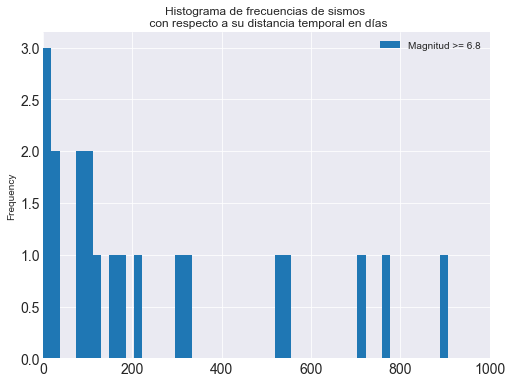

In [13]:
# 3.2 Estadística temporal de los sismos
#
sXdt=sismosIntensos.sort_values(['Fecha y Hora'])['Fecha y Hora'].diff(1).dropna()
m=sXdt.mean()
s=sXdt.std()

print ('media = ',m.days,'días')
print ('std = ',s.days,'días')
sXdt.apply(lambda x: x.days).plot.hist(bins=1000//7,
                                       title='Histograma de frecuencias de sismos \n con respecto a su distancia temporal en días',
                                       legend=True,label='Magnitud >= 6.8',figsize=(8,6),fontsize=14,xlim=(0,1000))

Con los datos actuales se espera un sismo cada 405 días, pero debido a que la desviación estándar es mucho mayor que la media (589 días), no es posible hacer una predicción de los sismos con esta información. 

Sin embargo, de acuerdo al histograma de frecuencias de la separación temporal entre sismos fuertes, hay una alta probabilidad de que dado un sismo fuerte ocurra otro igualmente intenso en un período de hasta dos semanas (los bines del historgrama son de 7 días).  

In [14]:
# 3.3 Coeficiente de correlación
mcorr = sismosIntensos[['Magnitud','Profundidad (km)']].corr()
print ('r_xy =',mcorr['Magnitud']['Profundidad (km)'])

r_xy = -0.18779570735175163


De acuerdo al coeficiente de correlación r_xy=-0.187, hay un 18% de correlación entre la profundidad y la magnitud de un sismo y esta correlación es negativa (a menor profundidad, mayor intensidad).

In [15]:
# 3.4 Mapa de energía
# Se usa como referencia la energía de un sismo de magnitud 6
Eref = (10**6)**(3./2.)
sismosIntensos=sismosIntensos.assign(Energia=(10**sismosIntensos['Magnitud'])**(3./2.)/Eref)
mexmap2 = folium.Map([16,-96],zoom_start=4)
emax=sismosIntensos['Energia'].max()
for idx in sismosIntensos.index:
    [lat,long,mag,e]=sismosIntensos.loc[idx,['Latitud','Longitud','Magnitud','Energia']]
    colorCode=intensityColor(mag)
    folium.CircleMarker(location=[lat,long],radius=100*(e/emax),popup=str(mag),color=colorCode,fillColor=colorCode,fill=True,opacity=0.8,fill_opacity=0.6).add_to(mexmap2)   
mexmap2

## Ejercicio 4: Buscando patrones antes de un evento de gran escala (medio difícil)

En la siguiente parte, vamos a ver si, de manera sencilla, podemos encontrar patrones de comportamiento sísmico antes de un evento de gran escala (Terremoto de magnitud >= 7.0). Como primer ejercicio, encuentre cuántos sismos hay con dicha magnitud:

1. Definan un intervalo de tiempo a analizar antes de un sismo de gran magnitud, por ejemplo, 24 horas ó 5 días (justifiquen su escala de tiempo)
2. Para todos los sismos de magnitud igual o mayor a 7.0, grafiquen el comportamiento de la región (en un ángulo sólido prudente) en el periodo de tiempo que escogieron antes del sismo. Busquen si hay algún patrón evidente y concluyan.

Como tip, la diferencia de dos estampas de tiempo genera un pd.Timedelta. La siguiente función puede tomar un arreglo ( o una serie) de `pd.Timedelta` para convertirlo en horas:

In [16]:
toHours = np.vectorize(lambda x : x.total_seconds()/3600)

Les va a ser mucho más fácil si trabajan en horas para este ejercicio.

In [17]:
# 4.0 Selecciona los sismos de magnitud mayor o igual a 7.0
sismosInt7 = sismos[(sismos['Magnitud']>=7.0)]
print ('Total de sismos con magnitud mayor a 7: ',sismosInt7.shape[0])

Total de sismos con magnitud mayor a 7:  18


In [ ]:
# Falto tiempo para terminar.

# Ejercicio 5: Qué más nos hace falta decir? (extra)

En esta última parte, pueden hacer **lo que quieran** con los datos. Agruparlos, clasificarlos, tienen libertad de sacar conclusiones de los datos que les he dado, pueden hacer algo con los mapas o hacer histogramas, queda en ustedes :)

In [ ]:
#Código aquí (si así lo quieren)